In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Applied\ AI\ course\ Assignments/Case\ Study\ 1

/content/drive/My Drive/Applied AI course Assignments/Case Study 1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import pickle

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss

from sklearn.metrics import mean_squared_error
from math import sqrt

import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Data Prep

In [ ]:
train = reduce_mem_usage(pd.read_csv('New_Data_processed/train_features_without_merchant.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('New_Data_processed/test_features_without_merchant.csv', index_col=0))

Mem. usage decreased to 99.94 Mb (71.4% reduction)
Mem. usage decreased to 62.01 Mb (70.9% reduction)


In [ ]:
with open('Low_and_High_prob_predictions/low_prob_test_predictions.pkl', 'rb') as f:
  test_low_pred = pickle.load(f)

with open('Low_and_High_prob_predictions/low_prob_train_predictions.pkl', 'rb') as f:
  train_low_pred = pickle.load(f)

with open('Low_and_High_prob_predictions/high_prob_train_predictions.pkl', 'rb') as f:
  train_high_pred = pickle.load(f)

with open('Low_and_High_prob_predictions/high_prob_test_predictions.pkl', 'rb') as f:
  test_high_pred = pickle.load(f)

#Load the full regression predictions

with open('train_predictions_full_regression.pkl', 'rb') as f:
  full_regression_train_preds = pickle.load(f)

with open('test_predictions_full_regression.pkl', 'rb') as f:
  full_regression_test_preds = pickle.load(f)


In [ ]:
train = train.merge(train_low_pred, on = 'card_id', how='left')
train = train.merge(train_high_pred, on = 'card_id', how='left')
train = train.merge(full_regression_train_preds, on = 'card_id', how='left')

test = test.merge(test_low_pred, on = 'card_id', how='left')
test = test.merge(test_high_pred, on = 'card_id', how='left')
test = test.merge(full_regression_test_preds, on = 'card_id', how='left')

In [ ]:
train_target = train['target']
test_card_id = test['card_id']

In [ ]:
columns = ['low_prob_score', 'high_prob_score', 'full_regression_prediction']
train = train[columns]
test = test[columns]

# Full Blend Model:

Model: Maybe a DecisionTreeClassifier or simple BayesianRegression model.

In [ ]:
folds_stack = KFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train,train_target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train.iloc[trn_idx], train_target.iloc[trn_idx]
    val_data, val_y = train.iloc[val_idx], train_target.iloc[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof[val_idx] = clf_3.predict(val_data)
    test_pred += clf_3.predict(test) / 5
    
print("CV RMSE:", np.sqrt(mean_squared_error(train_target.values, oof)))

fold 0
fold 1
fold 2
fold 3
fold 4
CV RMSE: 3.647436629867345


# Kaggle Submission

In [ ]:
kaggle_submission = pd.DataFrame()
kaggle_submission['card_id'] = test_card_id
kaggle_submission['target'] = test_pred

In [ ]:
kaggle_submission.to_csv('final_blended_model.csv', index=0)

# Observations:

I have listed down the different concentration of outliers tried in low and high prob models along with their scores to observe the trend and tune the structure better. (Below mentioned are %age of outliers in training data of each model)

    1. With same outlier concentrations as predicted from the classification model:
        --> Low_prob: 0.34% and High_prob: 6.95% 
       The model is overfitting slightly. Since Kaggle score is 3.63712 and CV score is 3.625799. 
    2. With outlier concentration as :
        --> Low_prob: 0.22% and High_prob: 25% 
        CV Score: 3.6380 and Kaggle score is 3.62621.
    3. With outlier concentration as:
        --> Low_prob: 0.11% and High_prob: 25%.
        CV score: 3.641588 and Kaggle score: 3.62126
    4. With outlier concentration as:
        --> Low_prob: 0.11% and High_prob: 30%.
        CV score: 3.6416316 and Kaggle score: 3.62116
    5. With outlier concentration as:
        --> Low_prob: 0.056% and High_prob: 50%.
        CV score: 3.645108 and Kaggle score: 3.61925
    6. With outlier concentration as:
        --> Low_prob: 0.056% and High_prob: 70%.
        CV score: 3.646318 and Kaggle score: 3.61896
    7. With outlier concentration as:
        --> Low_prob: 0.0056% and High_prob: 80%.
        CV score: 3.64743 and Kaggle score: 3.61901(But overall public RMSE score decreased so its just a random increase in comparison)
    

The best kaggle score from this architecture(3.61896) was still slightly higher than the score from full regression model(3.61559).

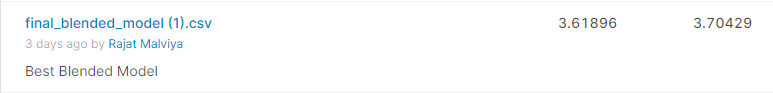